In [1]:
import torch
import torch.nn as nn



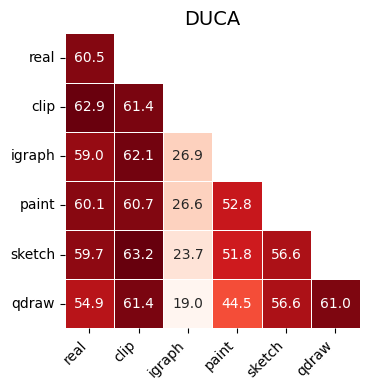

'/mnt/data/strictly_lower_triangular_duca_heatmap.png'

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def plot_strictly_lower_triangular_heatmap(data: list[list], labels: list[str], title: str):
    """
    Plots a heatmap showing only the strictly lower triangular part of the matrix (excluding the diagonal).

    Args:
    - data (list[list]): The 2D data to plot.
    - labels (list[str]): The labels for the x and y axes.
    - title (str): Title of the heatmap.
    - save_path (str): Path to save the heatmap.
    """
    # Convert data to a DataFrame
    df = pd.DataFrame(data, columns=labels, index=labels)
    # Mask the upper triangle including the diagonal
    mask = np.triu(np.ones_like(df, dtype=bool), k=0)
    mask[range(df.shape[0]), range(df.shape[0])] = 0
    # Plot heatmap
    plt.figure(figsize=(4, 4))  # Adjusted for compact size
    sns.heatmap(df, annot=True, fmt=".1f", cmap="Reds", square=True, cbar=False, linewidths=0.5, mask=mask)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    plt.close()
data = [
    [60.5],
    [62.9, 61.4, 62.1, 60.7, 63.2, 61.4],
    [59.0, 62.1, 26.9, 26.6, 23.7, 19.0],
    [60.1, 60.7, 26.6, 52.8, 51.8, 44.5],
    [59.7, 63.2, 23.7, 51.8, 56.6, 61.3],
    [54.9, 61.4, 19.0, 44.5, 56.6, 61.0],
]
labels = ["real", "clip", "igraph", "paint", "sketch", "qdraw"]
title = "DOCL Heatmap"
# Test the function for strictly lower triangular heatmap
df = plot_strictly_lower_triangular_heatmap(data, labels, "DUCA")

"/mnt/data/strictly_lower_triangular_duca_heatmap.png"


In [30]:
r = np.triu(np.ones_like(df))
r[range(r.shape[0]), range(r.shape[0])] = 0
r

array([[0., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.]])

In [ ]:
def compute_importances(model, data_loader, criterion, device):
    model.eval()
    
    importances = {}
    for name, param in model.named_parameters():
        importances[name] = torch.zeros_like(param)

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        for name, param in model.named_parameters():
            if param.grad.data is not None:
                importances[name] += param.grad.data ** 2
        model.zero_grad()

    for name, param in model.named_parameters():
        importances[name] /= len(data_loader)

    return importances

In [ ]:
def compute_loss(model, old_model_state_dict, prediction, target, importances, criterion=torch.nn.CrossEntropyLoss(), alpha=1.0):
    loss = criterion(prediction, target)    
    
    regularitzation_loss = 0
    for name, param in model.named_parameters():
        if name in old_model_state_dict:
            regularitzation_loss += importances[name] * (param - old_model_state_dict[name]).pow(2).sum()
    
    return loss + alpha * regularitzation_loss

In [ ]:
def add_importances(list_task_importances):
    importances = {}
    for task_importances in list_task_importances:
        for name, importance in task_importances.items():
            if name in importances:
                importances[name] += importance
            else:
                importances[name] = importance

    importances = {name: importance / len(list_task_importances) for name, importance in importances.items()}
    return importances